# 支持向量机——基于最小序列优化的实现

## 一些概念
* **分隔超平面：分类的决策边界**

* **间隔：数据集中所有点到分隔面的最小间隔的2倍**

* **支持向量：离分隔超平面最近的点**

## 分类器求解的优化问题
* 目标：我们希望支持向量距离分隔超平面尽可能远

类比点到直线的距离：
$d = \frac{|AX + BY + C|}{\sqrt(A^2 + B^2)}$

点到分隔面的距离：
$d = \frac{|w^TA + b|}{||w||}$ 

其中：w为支持向量，A为平面法向量，b为常数

分类器 `海维赛得阶跃函数` 对分类作用得到$label = f(w^Tx + b)$

$$s.t. \left\{\begin{array}{l}
 w^Tx + b = -1 & label = -1 \\ 
 w^Tx + b = +1 & label = +1
\end{array}\right.$$

类别标签用-1、1，是为了后期方便 $label*(w^Tx+b)$ 的标识和距离计算；
如果$ label*(w^Tx+b)>0$ 表示预测正确，否则预测错误。
现在目标很明确，就是要找到w和b，因此我们必须要找到最小间隔的数据点

目标函数: $\arg: max_{关于w, b} \left( min[label*(w^Tx+b)]*\frac{1}{||w||} \right) $

如果 $label*(w^Tx+b)>0$ 表示预测正确，也称函数间隔，$||w||$ 可以理解为归一化，也称几何间隔。

令 $label*(w^Tx+b)>=1$， 因为0～1之间，得到的点是存在误判的可能性，所以要保障$ min[label*(w^Tx+b)]=1$，才能更好降低噪音数据影响。
所以本质上是求 $\arg: max_{关于w, b} \frac{1}{||w||} $；

也就说，我们约束(前提)条件是: $label*(w^Tx+b)=1$

新的目标函数求解: $\arg: max_{关于w, b} \frac{1}{||w||} $

=> 就是求: $\arg: min_{关于w, b} ||w|| $ 

=> 就是求: $\arg: min_{关于w, b} (\frac{1}{2}*||w||^2)$ 

本质上就是求线性不等式的二次优化问题(求分隔超平面，等价于求解相应的凸二次规划问题)

通过拉格朗日乘子法，求二次优化问题
假设需要求极值的目标函数 (objective function) 为 f(x,y)，限制条件为 φ(x,y)=M # M=1
设g(x,y)=M-φ(x,y) # 临时φ(x,y)表示下文中 $label*(w^Tx+b)$
定义一个新函数: F(x,y,λ)=f(x,y)+λg(x,y)
a为λ（a>=0），代表要引入的拉格朗日乘子(Lagrange multiplier)

那么: $L(w,b,\alpha)=\frac{1}{2} * ||w||^2 + \sum_{i=1}^{n} \alpha_i * [1 - label * (w^Tx+b)]$

因为: $label*(w^Tx+b)>=1, \alpha>=0$ , 所以 $\alpha*[1-label*(w^Tx+b)]<=0$ , $\sum_{i=1}^{n} \alpha_i * [1-label*(w^Tx+b)]<=0$

当 $label*(w^Tx+b)>1 则 \alpha=0$ ，表示该点为非支持向量

相当于求解: $\max_{关于\alpha} L(w,b,\alpha) = \frac{1}{2} *||w||^2$

如果求: $\min_{关于w, b} \frac{1}{2} *||w||^2$ , 也就是要求:$ \min_{关于w, b} \left( max_{关于\alpha} L(w,b,\alpha)\right)$
现在转化到对偶问题的求解

$\min_{关于w, b} \left(max_{关于\alpha} L(w,b,\alpha) \right)  >= \max_{关于\alpha} \left(min_{关于w, b}\ L(w,b,\alpha) \right) $

现在分2步


先求: $min_{关于w, b} L(w,b,\alpha)=\frac{1}{2} * ||w||^2 + \sum_{i=1}^{n} \alpha_i * [1 - label * (w^Tx+b)]$

分别对$w,b$求导，得到：
$$ \left\{\begin{array}{l}
 L_{w}^{'}(w,b,\alpha) = ||w|| - \sum_{i=1}^m \alpha_{i}label_{i}x_{i} = 0  \\ 
 L_{b}^{'}(w,b,\alpha) = \sum_{i=1}^{m}\alpha_{i}label_{i} = 0 
\end{array}\right.$$
将上述结果带入$L(w,b,\alpha)$得到： 

$$L(w,b,\alpha) = \sum_{i=1}^m \alpha - \frac{1}{2}\sum_{i,j=1}^m label^{(i)} lanel^{(j)} \alpha_i \alpha_j <x_i,x_j>$$


终于得到课本上的公式: $\max_{关于\alpha} \left( \sum_{i=1}^{m} \alpha_i - \frac{1}{2} \sum_{i, j=1}^{m} label_i·label_j·\alpha_i·\alpha_j·<x_i, x_j> \right) $
约束条件: $a>=0$ 并且 $\sum_{i=1}^{m} a_i·label_i=0$

再求： $\max_{关于\alpha}L(w,b,\alpha)$

[SVM推导参考](https://zhuanlan.zhihu.com/p/35755150)
[SVM原理](https://zhuanlan.zhihu.com/p/49331510)

In [3]:
def load_dataset(filename):
    data_mat = []
    label_mat = []
    fr = open(filename)
    for line in fr.readlines():
        curline = line.strip().split('\t')
        data_mat.append([float(curline[0]), float(curline[1])])
        label_mat.append(float(curline[2]))
    return data_mat, label_mat

In [4]:
def select_Jrand(i, m):
    j = i
    while (j == i):
        j = int(np.random.uniform(0, m))
    return j

In [11]:
def clip_alpha(aj, h, l):
    if aj > h:
        aj = h
    if l > aj:
        aj = l
    return aj

In [12]:
dataset, label = load_dataset('testSet.txt')

## 简化版SMO算法

In [22]:
import numpy as np
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    """smoSimple

    Args:
        dataMatIn    特征集合
        classLabels  类别标签
        C   松弛变量(常量值)，允许有些数据点可以处于分隔面的错误一侧。
            控制最大化间隔和保证大部分的函数间隔小于1.0这两个目标的权重。
            可以通过调节该参数达到不同的结果。
        toler   容错率（是指在某个体系中能减小一些因素或选择对某个系统产生不稳定的概率。）
        maxIter 退出前最大的循环次数
    Returns:
        b       模型的常量值
        alphas  拉格朗日乘子
    """
    dataMatrix = np.mat(dataMatIn)
    # 矩阵转置 和 .T 一样的功能
    labelMat = np.mat(classLabels).transpose()
    m, n = np.shape(dataMatrix)

    # 初始化 b和alphas(alpha有点类似权重值。)
    b = 0
    alphas = np.mat(np.zeros((m, 1)))

    # 没有任何alpha改变的情况下遍历数据的次数
    iters = 0
    while (iters < maxIter):
        # w = calcWs(alphas, dataMatIn, classLabels)
        # print("w:", w)

        # 记录alpha是否已经进行优化，每次循环时设为0，然后再对整个集合顺序遍历
        alphaPairsChanged = 0
        for i in range(m):
            # print 'alphas=', alphas
            # print 'labelMat=', labelMat
            # print 'multiply(alphas, labelMat)=', multiply(alphas, labelMat)
            # 我们预测的类别 y[i] = w^Tx[i]+b; 其中因为 w = Σ(1~n) a[n]*label[n]*x[n]
            fXi = float(np.multiply(alphas, labelMat).T*(dataMatrix*dataMatrix[i, :].T)) + b
            # 预测结果与真实结果比对，计算误差Ei
            Ei = fXi - float(labelMat[i])

            # 约束条件 (KKT条件是解决最优化问题的时用到的一种方法。我们这里提到的最优化问题通常是指对于给定的某一函数，求其在指定作用域上的全局最小值)
            # 0<=alphas[i]<=C，但由于0和C是边界值，我们无法进行优化，因为需要增加一个alphas和降低一个alphas。
            # 表示发生错误的概率: labelMat[i]*Ei 如果超出了 toler， 才需要优化。至于正负号，我们考虑绝对值就对了。
            '''
            # 检验训练样本(xi, yi)是否满足KKT条件
            yi*f(i) >= 1 and alpha = 0 (outside the boundary)
            yi*f(i) == 1 and 0<alpha< C (on the boundary)
            yi*f(i) <= 1 and alpha = C (between the boundary)
            '''
            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):

                # 如果满足优化的条件，我们就随机选取非i的一个点，进行优化比较
                j = select_Jrand(i, m)
                # 预测j的结果
                fXj = float(np.multiply(alphas, labelMat).T*(dataMatrix*dataMatrix[j, :].T)) + b
                Ej = fXj - float(labelMat[j])
                alphaIold = alphas[i].copy()
                alphaJold = alphas[j].copy()

                # L和H用于将alphas[j]调整到0-C之间。如果L==H，就不做任何改变，直接执行continue语句
                # labelMat[i] != labelMat[j] 表示异侧，就相减，否则是同侧，就相加。
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                # 如果相同，就没法优化了
                if L == H:
                    print("L==H")
                    continue

                # eta是alphas[j]的最优修改量，如果eta==0，需要退出for循环的当前迭代过程
                # 参考《统计学习方法》李航-P125~P128<序列最小最优化算法>
                eta = 2.0 * dataMatrix[i, :]*dataMatrix[j, :].T - dataMatrix[i, :]*dataMatrix[i, :].T - dataMatrix[j, :]*dataMatrix[j, :].T
                if eta >= 0:
                    print("eta>=0")
                    continue

                # 计算出一个新的alphas[j]值
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta
                # 并使用辅助函数，以及L和H对其进行调整
                alphas[j] = clip_alpha(alphas[j], H, L)
                # 检查alpha[j]是否只是轻微的改变，如果是的话，就退出for循环。
                if (abs(alphas[j] - alphaJold) < 0.00001):
                    print("j not moving enough")
                    continue
                # 然后alphas[i]和alphas[j]同样进行改变，虽然改变的大小一样，但是改变的方向正好相反
                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j])
                # 在对alpha[i], alpha[j] 进行优化之后，给这两个alpha值设置一个常数b。
                # w= Σ[1~n] ai*yi*xi => b = yj- Σ[1~n] ai*yi(xi*xj)
                # 所以:   b1 - b = (y1-y) - Σ[1~n] yi*(a1-a)*(xi*x1)
                # 为什么减2遍？ 因为是 减去Σ[1~n]，正好2个变量i和j，所以减2遍
                b1 = b - Ei- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i, :]*dataMatrix[i, :].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i, :]*dataMatrix[j, :].T
                b2 = b - Ej- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i, :]*dataMatrix[j, :].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j, :]*dataMatrix[j, :].T
                if (0 < alphas[i]) and (C > alphas[i]):
                    b = b1
                elif (0 < alphas[j]) and (C > alphas[j]):
                    b = b2
                else:
                    b = (b1 + b2)/2.0
                alphaPairsChanged += 1
                print("iter: %d i:%d, pairs changed %d" % (iters, i, alphaPairsChanged))
        # 在for循环外，检查alpha值是否做了更新，如果更新则将iter设为0后继续运行程序
        # 直到更新完毕后，iter次循环无变化，才退出循环。
        if (alphaPairsChanged == 0):
            iters += 1
        else:
            iters = 0
        print("iteration number: %d" % iters)
    return b, alphas
                
b, alphas = smoSimple(dataset, label, 0.6, 0.001, 40)

L==H
L==H
iter: 0 i:2, pairs changed 1
j not moving enough
iter: 0 i:4, pairs changed 2
j not moving enough
iter: 0 i:8, pairs changed 3
L==H
iter: 0 i:17, pairs changed 4
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
iteration number: 0
iter: 0 i:2, pairs changed 1
j not moving enough
iter: 0 i:7, pairs changed 2
j not moving enough
j not moving enough
j not moving enough
iter: 0 i:23, pairs changed 3
j not moving enough
j not moving enough
L==H
j not moving enough
iter: 0 i:55, pairs changed 4
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
iter: 0 i:4, pairs changed 1
iter: 0 i:8, pairs changed 2
j not moving enough
iter: 0 i:23, pairs changed 3
j not moving enough
L==H
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not m

j not moving enough
j not moving enough
iter: 3 i:52, pairs changed 2
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
iter: 3 i:17, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough


j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not moving enough
iteration number: 4
j not moving enough
j not moving enough
j not moving enough
iteration number: 5
j not moving enough
iter: 5 i:54, pairs changed 1
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
iter: 2 i:52, pairs changed 1
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough


iteration number: 4
j not moving enough
j not moving enough
j not moving enough
iteration number: 5
j not moving enough
j not moving enough
j not moving enough
iteration number: 6
j not moving enough
j not moving enough
j not moving enough
iteration number: 7
j not moving enough
j not moving enough
j not moving enough
iteration number: 8
j not moving enough
j not moving enough
j not moving enough
iteration number: 9
j not moving enough
j not moving enough
j not moving enough
iteration number: 10
j not moving enough
j not moving enough
j not moving enough
iteration number: 11
iter: 11 i:17, pairs changed 1
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
iteration number: 4
j not moving enough
j not moving enough
iteration number: 5
j not moving enough
j not m

In [23]:
print(alphas[alphas>0])

[[0.15258776 0.15915986 0.0552097  0.36695732]]


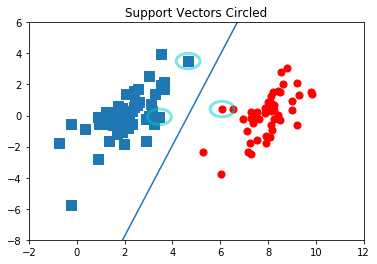

In [24]:
from numpy import *
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

xcord0 = []
ycord0 = []
xcord1 = []
ycord1 = []
markers =[]
colors =[]
fr = open('testSet.txt')#this file was generated by 2normalGen.py
for line in fr.readlines():
    lineSplit = line.strip().split('\t')
    xPt = float(lineSplit[0])
    yPt = float(lineSplit[1])
    label = int(lineSplit[2])
    if (label == -1):
        xcord0.append(xPt)
        ycord0.append(yPt)
    else:
        xcord1.append(xPt)
        ycord1.append(yPt)

fr.close()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xcord0,ycord0, marker='s', s=90)
ax.scatter(xcord1,ycord1, marker='o', s=50, c='red')
plt.title('Support Vectors Circled')
circle = Circle((4.6581910000000004, 3.507396), 0.5, facecolor='none', edgecolor=(0,0.8,0.8), linewidth=3, alpha=0.5)
ax.add_patch(circle)
circle = Circle((3.4570959999999999, -0.082215999999999997), 0.5, facecolor='none', edgecolor=(0,0.8,0.8), linewidth=3, alpha=0.5)
ax.add_patch(circle)
circle = Circle((6.0805730000000002, 0.41888599999999998), 0.5, facecolor='none', edgecolor=(0,0.8,0.8), linewidth=3, alpha=0.5)
ax.add_patch(circle)
#plt.plot([2.3,8.5], [-6,6]) #seperating hyperplane
b = -3.75567; w0=0.8065; w1=-0.2761
x = arange(-2.0, 12.0, 0.1)
y = (-w0*x - b)/w1
ax.plot(x,y)
ax.axis([-2,12,-8,6])
plt.show()

## 完整版Platt smo

In [19]:
class optStruct:
    def __init__(self, dataMatIn, C, toler):
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = np.shape(dataMatIn[0])
        self.alphas = np.mat(np.zeros((self.m, 1)))
        self.b = 0
        self.eCache = np.mat(np.mat(zeros(self.m, 2)))

In [20]:
def calcEk(oS, k):
    fxk = float(np.multiply(oS.alphas, oS.labelMat).T * (oS.X * os.X[k, :].T)) + oS.b
    Ek = fxk - float(oS.labelMat[k])
    return Ek

In [21]:
def selectJ(i, oS, Ei):
    maxK = -1
    maxDeltaE = 0
    Ej = 0
    oS.eCache[i] = [1, Ei]
    validEcacheList = nonzero(oS.eCache[:, 0].A)[0]
    if len(validEcacheList) > 1:
        for k in validEcacheList:
            if k == i: continue
            Ek = calcEk(oS, k)
            deltaE = abs(Ei - Ek)
            if deltaE > maxDeltaE:
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK, Ej
    else:
        j = selectJ(i, os.m)
        Ej = calcEk(os, j)
    return j, Ej


In [25]:
def updateEk(oS, k):
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1, Ek]

In [26]:
def innerL(i, oS):
    Ei = calcEk(oS, i)
    if (oS.labelMat[i] * Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i] * Ei > oS.tol) and (oS.alphas[i] > 0)):
        j, Ej = selectJ(i, oS, Ei)
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[i].copy()
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0. oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if  L == H:
            print('L==H')
            return 0
        eta = 2.0 * oS.X[i,:] * oS.X[j, :].T - oS.X[i, :] * oS.X[i, :].T - oS.X[j, :] * oS.X[j, :].T
        if eta >= 0:
            print('eta>=0')
            return 0
        oS.alphas[j] -= oS.labelMat[j] * (Ei - Ej)/eta
        oS.alphas[j] = clip_alpha(oS.alphas[j], H, L)
        updateEk(oS, j)
        if (abs(oS.alphas[j] - alphaJold) < 0.00001):
            print('j not moving enough')
            return 0
        oS.alphas[i] += oS.labelMat[j] * oS.labelMat[i] * (alphaJold - oS.alphas[j])
        updateEk(oS, i)
        b1 = oS.b - Ei - oS.labelMat[i] * (oS.alphas[i] - alphaIold) * oS.X[i, :] * oS.X[i, :].T 
                    - oS.labelMat[j] * (oS.alphas[j] - alphaJold) * oS.X[i, :] * oS.X[j,:].T
        b2 = oS.b - Ej - oS.labelMat[i] * (oS.alphas[i] - alphaIold) * oS.X[i, :] * oS.X[j, :].T 
                    - oS.labelMat[j] * (oS.alphas[j] - alphaJold) * oS.X[j, :] * oS.X[j,:].T
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): 
            oS.b = b1
        elif (0 < oS.alphas[i]) and (oS.C > oS.alphas[j]):
            oS.b = b2
        else:
            oS.b = (b1 + b2) / 2.0
        return 1
    else:
        return 0

SyntaxError: invalid syntax (<ipython-input-26-a019d56e4aaa>, line 3)